In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import json
import os
import shutil
import pickle
import sys
sys.path.append("..")

from PJT_Frustration_Induced_Crystallize.main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
# cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [ ]:
phaseLags = [0.6 * np.pi]  # 0.6, 0.9
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10
strengthKs = np.linspace(4, 20, 19)
distanceD0s = np.linspace(0.3, 1.1, 19)
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        boundaryLength=7, speedV=3,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

In [133]:
phaseLags = [0.9 * np.pi]  # 0.6, 0.9
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10 
strengthKs = np.linspace(1, 20, 19)
distanceD0s = np.linspace(0.1, 3, 19)
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]
models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        boundaryLength=7, speedV=3,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

In [ ]:
sas = list()
for model in tqdm(models):
    try:
        sa = StateAnalysis(model)
    except:
        sa = None
    sas.append(sa)

In [134]:
savePath = (
    f"last_state/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)

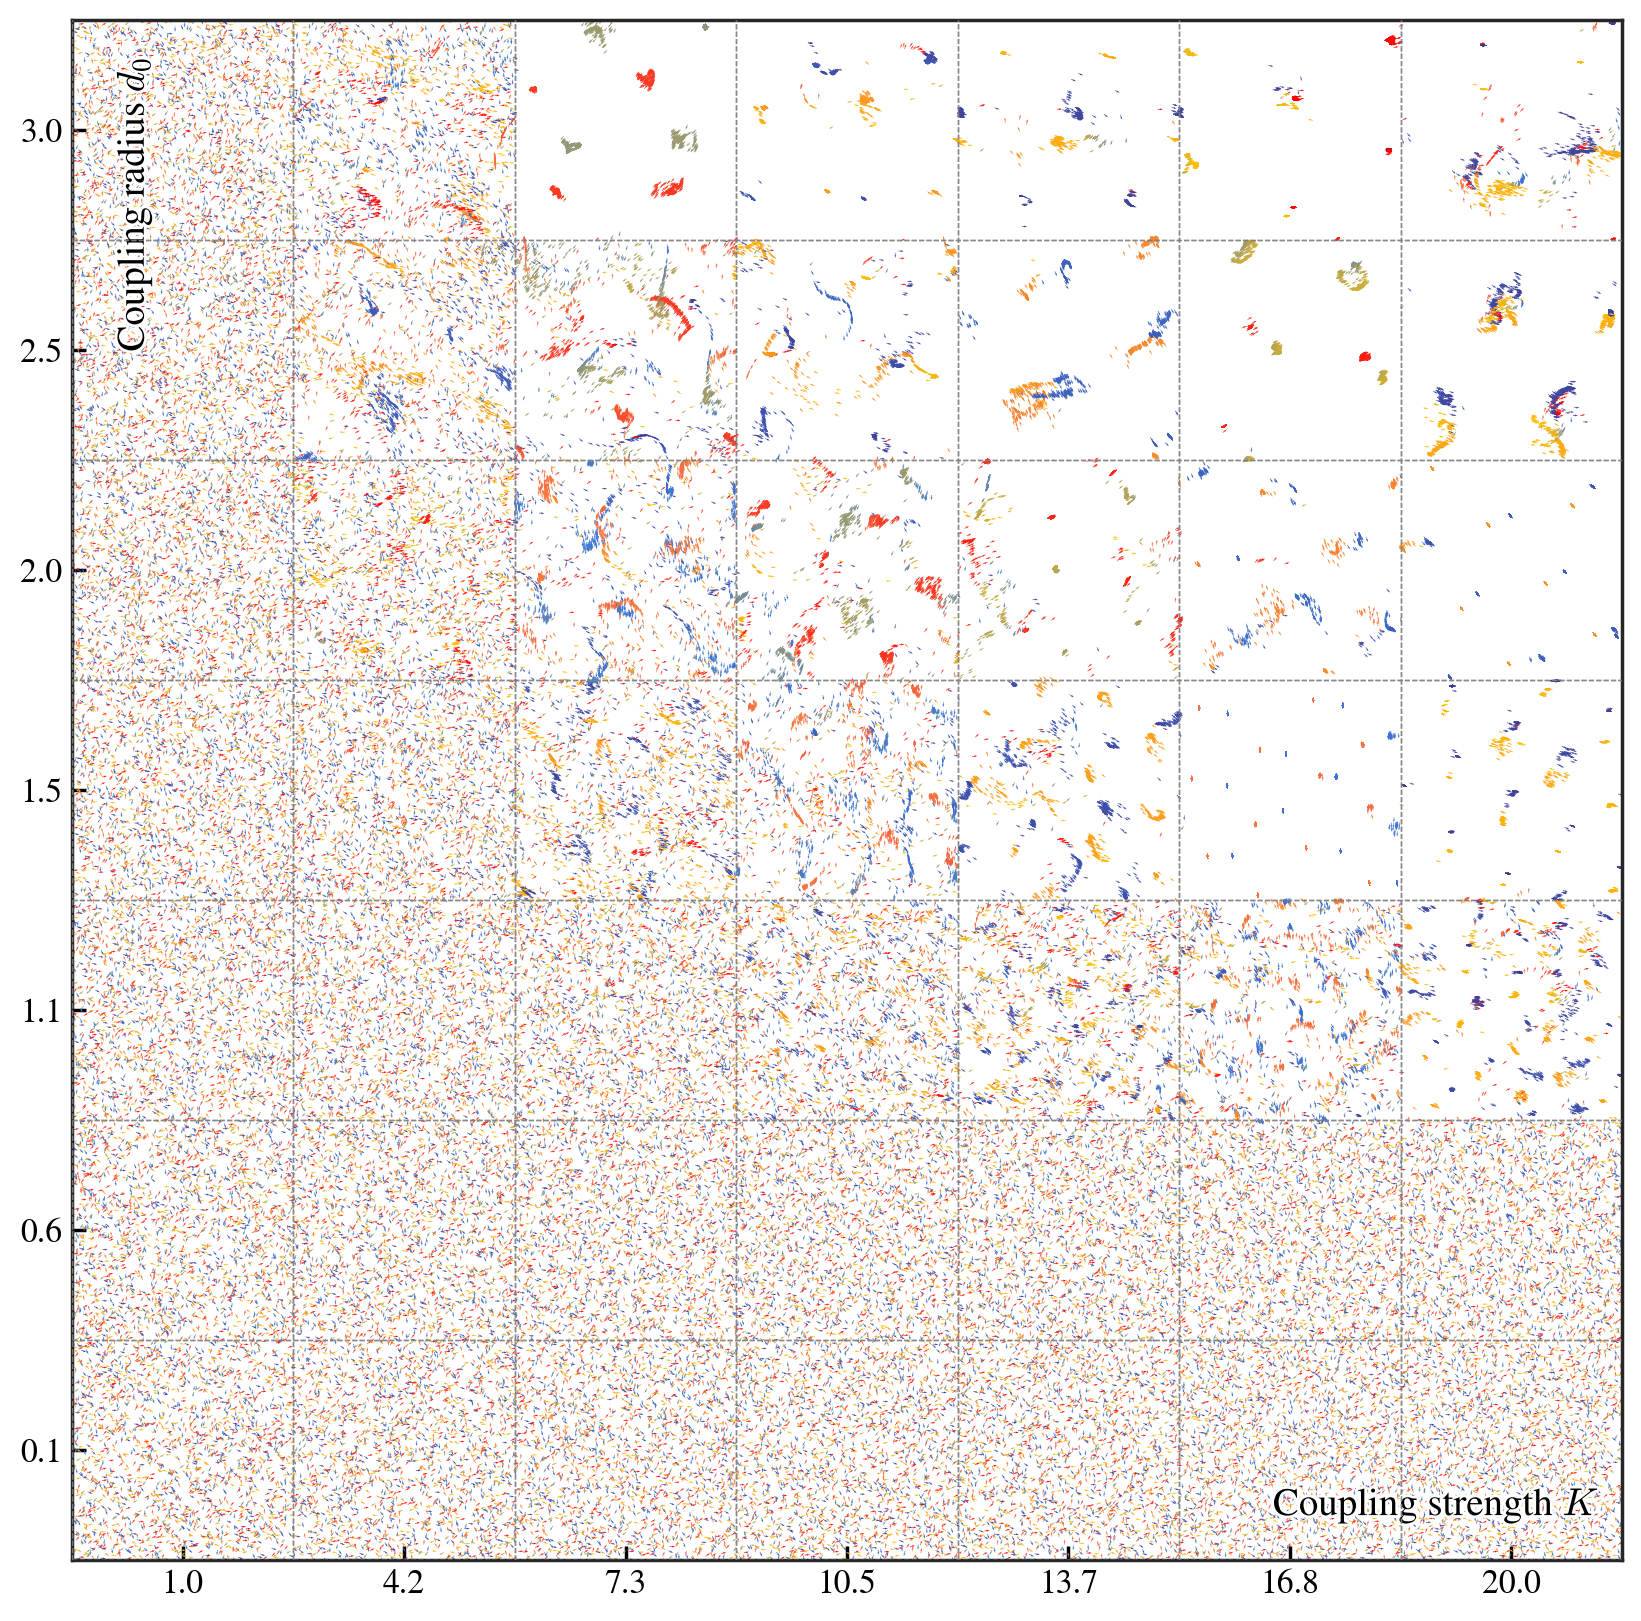

In [135]:
from matplotlib.patheffects import withStroke

colParams = distanceD0s[::3]
rowParams = strengthKs[::3]
colorsBy = "phase"

# fig, ax = plt.subplots(figsize=(len(rowParams) * 4, len(colParams) * 4))
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(len(colParams) * len(rowParams)):
    row = i // len(rowParams)
    col = i % len(rowParams)
    sa = [sa for sa in sas 
          if (sa.model.strengthK == rowParams[row]) and
             (sa.model.distanceD0 == colParams[col])][0]
    
    positionShift = np.array([row, col]) * sa.model.boundaryLength
    positionX, phaseTheta = sa.get_state(-1)
    positionX = positionX + positionShift
    if colorsBy == "freq":
        colors = (
            ["red"] * (sa.model.freqOmega >= 0).sum() + 
            ["#414CC7"] * (sa.model.freqOmega < 0).sum()
        )
    elif colorsBy == "phase":
        colors = [cmap(i) for i in
            np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)
        ]

    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta), np.sin(phaseTheta), 
        color=colors,
        scale=300, width=0.0004 / len(rowParams) * 7
    )
    ax.axhline(
        y=col * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )
    ax.axvline(
        x=row * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )

boundaryLength = models[0].boundaryLength
plt.xlim(0, len(rowParams) * boundaryLength)
plt.ylim(0, len(colParams) * boundaryLength)
plt.xticks(
    np.arange(0, len(rowParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{k:.1f}" for k in rowParams]
)
plt.yticks(
    np.arange(0, len(colParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{d:.1f}" for d in colParams]
)

text1 = plt.text(len(rowParams) * boundaryLength * 0.88, len(rowParams) * boundaryLength * 0.035,
                 "Coupling strength $K$", # weight="bold",
                 fontsize=14, ha="center", va="center")
text2 = plt.text(len(rowParams) * boundaryLength * 0.04, len(rowParams) * boundaryLength * 0.88,
                 "Coupling radius $d_0$", # weight="bold",
                 fontsize=14, ha="center", va="center", rotation=90)
for text in [text1, text2]:
    text.set_path_effects([withStroke(linewidth=2, foreground='white')])
plt.tick_params(length=5, direction="in")
# plt.savefig(
#     f"figs/{sa.model.__class__.__name__}_"
#     f"varying_strengthK_and_distanceD0_{colorsBy}_"
#     f"a{phaseLags[0]:.2f}_Do{deltaOmegas[0]}"
#     f"{'initPhaseTheta,' if sa.model.initPhaseTheta is not None else ''}"
#     f"_aN{sa.model.agentsNum}_dist{sa.model.freqDist}.png", 
#     bbox_inches="tight"
# )

In [123]:
def calc_lattice_constants(sa: StateAnalysis, plot: bool = False, lookIdx: int = -1):

    sa: StateAnalysis
    model = sa.model
    shift = np.array([0., 0.])
    analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

    classes, centers = sa.calc_classes_and_centers(classDistance=analysisRadius, lookIdx=lookIdx)
    if len(classes) > model.agentsNum * 0.2:
        # print(f"Too many classes: {len(classes)} > {model.agentsNum * 0.2}, skipping.")
        return [], []
    numInClasses = np.array([len(c) for c in classes])
    # zScoreNum = stats.zscore(numInClasses)
    # classes = [classes[c] for c in range(len(classes)) 
    #            if (zScoreNum[c] > -0.4) and (numInClasses[c] > 10)]
    numThres = np.median(numInClasses[numInClasses > 10]) * 0.
    classes = [classes[c] for c in range(len(classes))
               if (numInClasses[c] > max(numThres, 10))]
    centers = np.mod(centers + shift, model.boundaryLength)
    if len(classes) <= 1:
        # print("Not enough classes, skipping.")
        return [], []

    classCenters: List[np.ndarray] = []
    for c in classes:
        singleClassCenters = centers[c]

        maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
        subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
        maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
        subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

        singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
        classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
        classCenters.append(classCenter)
    classCenters: np.ndarray = np.array(classCenters)

    edges, ajdClassCenters = sa.calc_nearby_edges(
        classCenters=classCenters, 
        stdMulti=0.3,
        relativeDistance=False
    )

    classAnalRadius = list()

    for _, oscIdx in enumerate(classes):
        freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]
        meanFreq = freqOmega.mean()
        analRadius = model.speedV / np.abs(meanFreq - model.strengthK * np.sin(model.phaseLagA0))
        
        classAnalRadius.append(analRadius)

    classAnalRadius = np.array(classAnalRadius)
    edgeDistances = np.array([
        sa.calc_replative_distance(ajdClassCenters[edge[0]], ajdClassCenters[edge[1]]) 
        for edge in edges
    ])

    if plot:
        sa.plot_spatial(colorsBy="phase", index=-1, shift=shift)
        plt.scatter(
            classCenters[:, 0], classCenters[:, 1],
            facecolor="white", s=30, edgecolor="black", lw=1.5
        )
        for edge in edges:
            plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
                    color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)

    return classAnalRadius, edgeDistances

In [136]:
# selectedSas = sas
selectD0s = distanceD0s[(0.6 < distanceD0s)]  #  & (distanceD0s < 1.03)
selectKs = strengthKs[14 < strengthKs]
selectedSas = [
    sa for sa in sas 
    if (sa is not None) and 
    (sa.model.distanceD0 in selectD0s) and 
    (sa.model.strengthK in selectKs)
]

classAnalRadius = dict()
edgeDistances = dict()

for sa in tqdm(selectedSas, total=len(selectedSas)):
    key = (sa.model.strengthK, sa.model.distanceD0)
    classAnalRadius[key] = []
    edgeDistances[key] = []
    for lookIdx in [-1]:
        analRadius, edgeDistance = calc_lattice_constants(sa, plot=False, lookIdx=lookIdx)
        classAnalRadius[key].append(analRadius)
        edgeDistances[key].append(edgeDistance)
    # print(rf"$K={sa.model.strengthK:.2f},d_0={sa.model.distanceD0:.2f}$")

  0%|          | 0/90 [00:00<?, ?it/s]

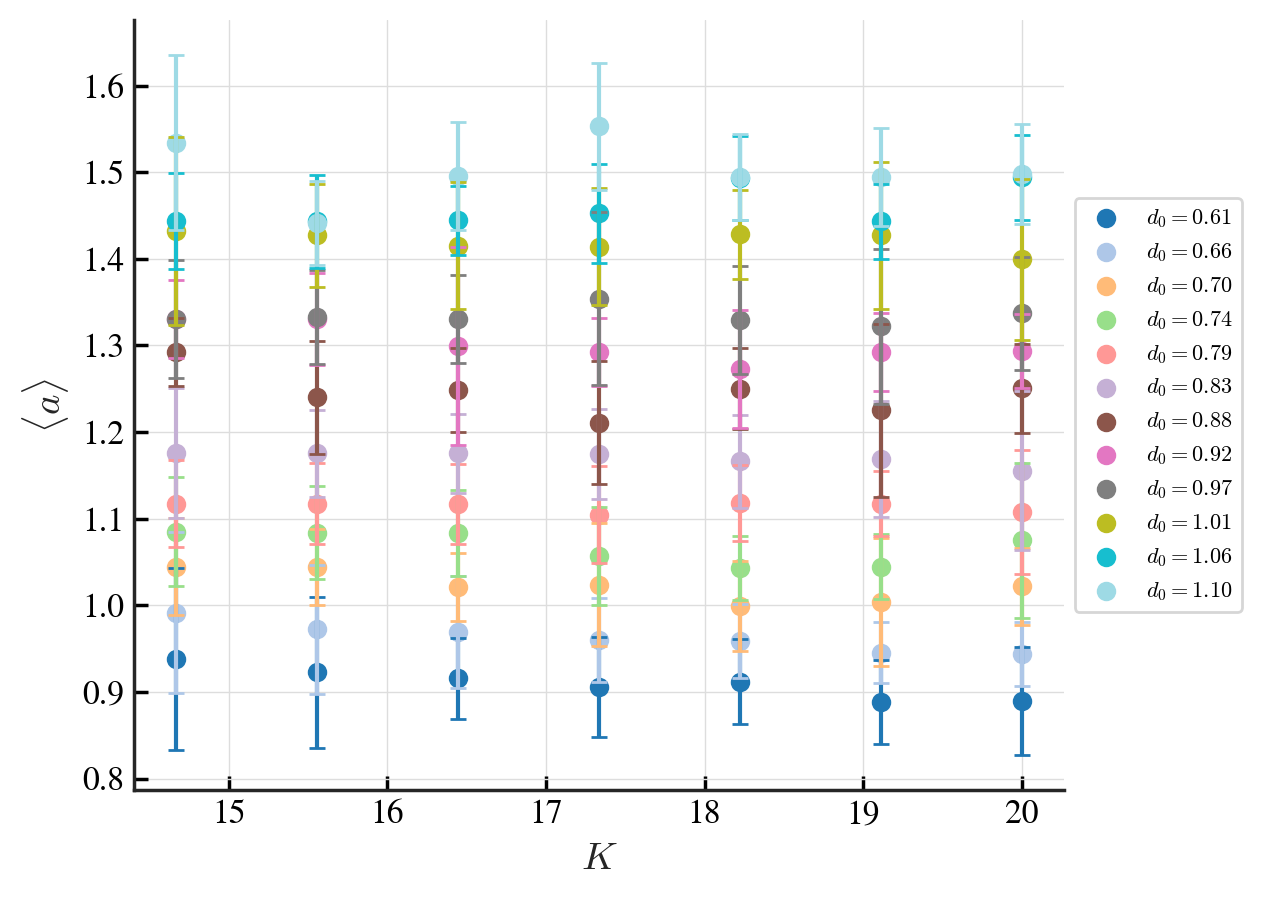

In [7]:
selectD0s = distanceD0s[:][(0.6 < distanceD0s)]
selectKs = strengthKs[:][strengthKs > 14]

fig, ax = plt.subplots(figsize=(6, 5))
colors = plt.cm.tab20(np.linspace(0, 1, len(selectD0s)))

for i, selectD0 in enumerate(selectD0s[:]):
    meanEdgeDistances = np.array([np.mean(edgeDistances[(strengthK, selectD0)]) for strengthK in selectKs])
        
    stdEdgeDistances = np.array([np.std(edgeDistances[(strengthK, selectD0)]) for strengthK in selectKs])
    linspaceKs = np.linspace(selectKs[0], selectKs[-1], 100)
    analysisDis = selectD0 + 2 * model.speedV / np.abs(linspaceKs * np.sin(model.phaseLagA0))

    color = colors[i]
    # plt.plot(linspaceKs, analysisDis, ls="--", color=color)
    ax.errorbar(selectKs, meanEdgeDistances, yerr=stdEdgeDistances,
                color="none", ecolor=color, capsize=3, ms=4)
    ax.scatter(selectKs, meanEdgeDistances, color=color, label=f"$d_0={selectD0:.2f}$")

# plt.ylim(0.5, 2)
plt.tick_params(length=5, direction="in")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.xlabel(r"$K$", fontsize=14)
plt.ylabel(r"$\langle a \rangle$", fontsize=14)
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("figs/lattice_constant.pdf", bbox_inches="tight")

In [126]:
from scipy.linalg import eig
from scipy.special import j1


def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L0 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        if m == 1 or m == -1:
            L0[i,i] = besselTerm * np.exp(-m * alpha * 1j)
    
    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line
    
    H = L0 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    eigenvalues = eigenvalues[np.argsort(eigenvalues.real)]

    return eigenvalues

def calc_break_K(kValues: np.ndarray, params: dict, M: int = 10, decimals: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)
    rawEvals = allEvals.copy()
    if decimals is not None:
        allEvals = allEvals.round(decimals=decimals)

    posK = []
    posEvals = []
    posRawEvals = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        rawRealEvals = rawEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        if len(positiveIdx) > 0:
            posK.append(kValues[positiveIdx[0]])
            posEvals.append(realEvals[positiveIdx[0]])
            posRawEvals.append(rawRealEvals[positiveIdx[0]])

    return np.array(posK), np.array(posEvals), np.array(posRawEvals)

def get_first_break_k(params: Dict[str, float], strict: bool = True, decimals: int = 10):
    alphaPluss = np.arange(0, 0.03, 0.0001)
    firstBreakK = None
    for alphaPlus in alphaPluss:
        params["alpha"] = 0.5 * np.pi + alphaPlus

        # kValues = np.arange(1, 100) * 2 * np.pi / params["boundaryLength"]
        kValues = np.linspace(1, 10, 500)

        posK, posEvals, posRawEvals = calc_break_K(kValues, params, M=10, decimals=decimals)
        if len(posK) == 1:
            firstBreakK = posK[0]
            break
        if len(posK) > 1:
            if strict:
                assert False, "More than one positive k* found"
            else:
                if sum(posRawEvals == np.max(posRawEvals)) > 1:
                    assert False, "Multiple maxima found"
                firstBreakK = posK[np.argmax(posRawEvals)]
                break

    if firstBreakK is None:
        assert False, "No positive k* found"

    return firstBreakK

In [137]:
selectD0s = distanceD0s[(0.6 < distanceD0s)]  #  & (distanceD0s < 1.03)
selectKs = strengthKs[14 < strengthKs]
firstBreakKs = dict()
for K, d0 in tqdm(product(selectKs, selectD0s), total=len(selectKs) * len(selectD0s)):
    params = {
        'v': 3,
        'K': K,
        'd0': d0,
        "boundaryLength": models[0].boundaryLength,
    }
    firstBreakK = get_first_break_k(params=params, strict=False, decimals=3)
    # firstBreakK = get_first_break_k(params=params)
    firstBreakKs[(K, d0)] = firstBreakK

  0%|          | 0/90 [00:00<?, ?it/s]

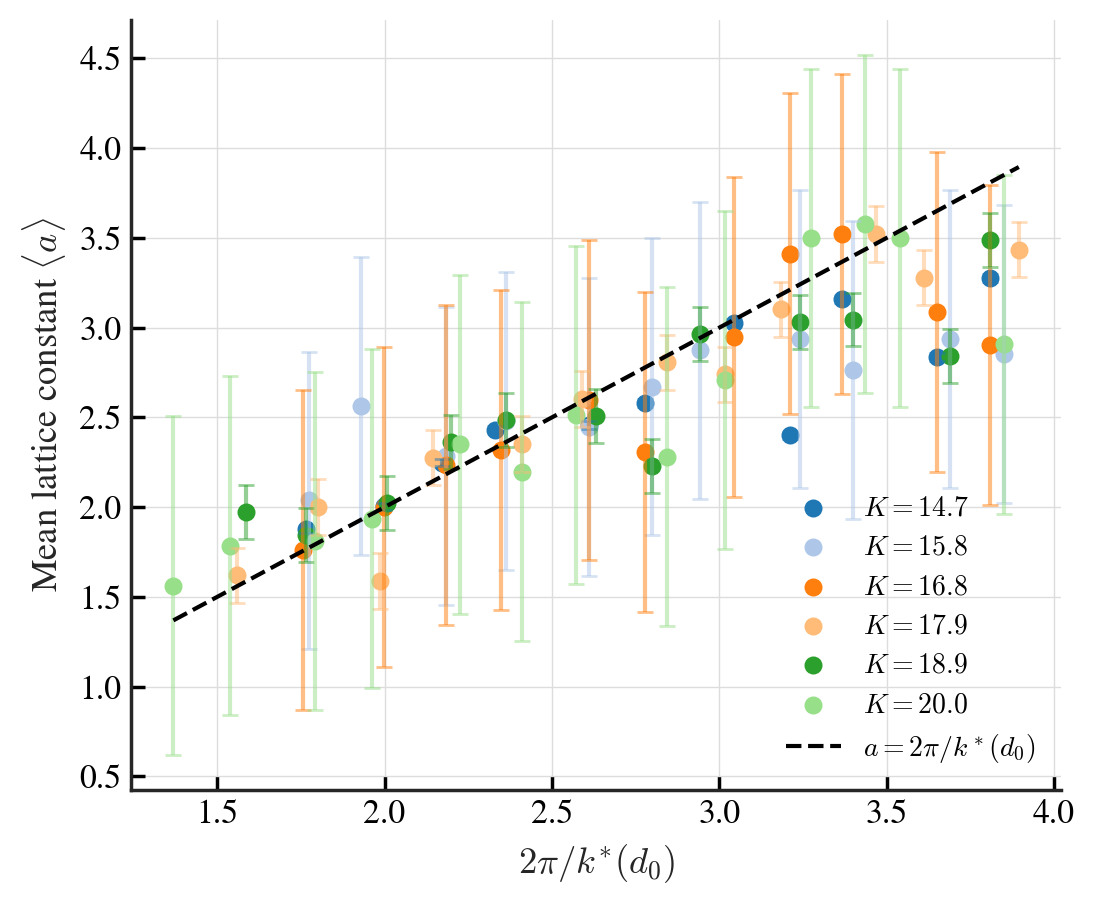

In [138]:
colors = plt.cm.tab20(np.linspace(0, 1, len(strengthKs)))

selectD0s = distanceD0s[:][(0.6 < distanceD0s)]
selectKs = strengthKs[:][14 < strengthKs]
# kValues = np.linspace(0.0001, 10, 500)
phaseLagA0 = 0.6 * np.pi
speedV = 3
totalKStars = list()
totalMeanEdgeDistances = list()

for i, K in enumerate(selectKs):
    kStars = list()
    meanEdgeDistances = list()
    
    for d0 in selectD0s:
        firstPosK = firstBreakKs[(K, d0)]
        edgeDistance = edgeDistances[(K, d0)][0]
        if len(edgeDistance) < 20:
            continue
        meanEdgeDistance = np.mean(edgeDistance) - speedV / np.abs(K * np.sin(phaseLagA0))
        stdEdgeDistance = np.std(edgeDistance)
        kStars.append(2 * np.pi / firstPosK)
        meanEdgeDistances.append(meanEdgeDistance)
    
    color=colors[i]
    plt.scatter(
        kStars, meanEdgeDistances, 
        s=30, alpha=1, label=f"$K={K:.1f}$", color=color
    )
    plt.errorbar(kStars, meanEdgeDistances, yerr=stdEdgeDistance,
                 color="none", ecolor=color, capsize=3, alpha=0.5)
    totalKStars += kStars
    totalMeanEdgeDistances += meanEdgeDistances

# 拟合
argsort = np.argsort(totalKStars)
totalKStars = np.array(totalKStars)[argsort]
totalMeanEdgeDistances = np.array(totalMeanEdgeDistances)[argsort]
# slope, intercept, r_value, p_value, std_err = stats.linregress(
#     totalKStars, totalMeanEdgeDistances
# )
slope, intercept = 1, 0
plt.plot(totalKStars, 
         slope * totalKStars + intercept,
         color="black", linestyle="--", linewidth=1.5, label=rf"$a=2\pi/k^*(d_0)$")

plt.tick_params(length=5, direction="in")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.xlabel(r"$2\pi / k^{*}(d_0)$")
plt.ylabel(r"Mean lattice constant $\langle a\rangle$")
plt.legend(frameon=False, loc="lower right", fontsize=10)
# plt.savefig("figs/lattice_constant_vs_kstar.pdf", bbox_inches="tight")

In [139]:
savePath = (
    f"temp/LatticeConstant_{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.pkl"
)

with open(savePath, "wb") as f:
    pickle.dump((firstBreakKs, edgeDistances), f)

In [ ]:
datasAndParams = list()

phaseLags = [0.6 * np.pi]  # 0.6, 0.9
boundaryLengths = [5, 7, 9]
Kd0Ranges = [
    (np.linspace(4, 20, 19), np.linspace(0.3, 1.1, 19)),
    (np.linspace(1, 20, 19), np.linspace(0.1, 3, 19))
]

for boundaryLength, phaseLag in product(boundaryLengths, phaseLags):
    firstBreakKs, edgeDistances = dict(), dict()
    for Kd0Range in Kd0Ranges:
        strengthKs, distanceD0s = Kd0Range
        models = [
            PhaseLagPatternFormation(
                strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
                boundaryLength=boundaryLength,
                freqDist="uniform", initPhaseTheta=None,
                omegaMin=0, deltaOmega=0, 
                agentsNum=2000, dt=0.005,
                tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
                randomSeed=10, overWrite=False
            )
            for strengthK in strengthKs
            for distanceD0 in distanceD0s
        ]
        # load sas
        savePath = (
            f"last_state/{models[0].__class__.__name__}_"
            f"{models[0].freqDist}_"
            f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
            f"phaseLagA0{models[0].phaseLagA0:.3f}_"
            f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
            f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
            f"bL{models[0].boundaryLength}_"
            f"lastState.h5"
        )
        if not os.path.exists(savePath):
            continue
        modelsNum = len(models)

        sas = list()
        allPositionX = pd.read_hdf(savePath, key="positionX")
        allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
        allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
        allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

        for i, model in enumerate(models):
            sa = StateAnalysis()
            sa.model = model
            sa.totalPositionX = np.array([allPositionX[i]])
            sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
            sas.append(sa)
        # calc edge distances
        selectD0s = distanceD0s[(0.6 < distanceD0s)]  #  & (distanceD0s < 1.03)
        selectKs = strengthKs[14 < strengthKs]
        selectedSas = [
            sa for sa in sas 
            if (sa is not None) and 
            (sa.model.distanceD0 in selectD0s) and 
            (sa.model.strengthK in selectKs)
        ]

        classAnalRadius = dict()
        edgeDistances = dict()

        for sa in tqdm(selectedSas, total=len(selectedSas), desc="Calculating edge distances"):
            key = (sa.model.strengthK, sa.model.distanceD0)
            classAnalRadius[key] = []
            edgeDistances[key] = []
            for lookIdx in [-1]:
                analRadius, edgeDistance = calc_lattice_constants(sa, plot=False, lookIdx=lookIdx)
                classAnalRadius[key].append(analRadius)
                edgeDistances[key].append(edgeDistance)
        # calc break ks
        firstBreakKs = dict()
        for K, d0 in tqdm(product(selectKs, selectD0s), total=len(selectKs) * len(selectD0s), 
                          desc="Calculating break ks"):
            params = {
                'v': 3,
                'K': K,
                'd0': d0,
                "boundaryLength": models[0].boundaryLength,
            }
            firstBreakK = get_first_break_k(params=params, strict=False, decimals=3)
            # firstBreakK = get_first_break_k(params=params)
            firstBreakKs[(K, d0)] = firstBreakK
        # save
        savePath = (
            f"temp/LatticeConstant_{models[0].__class__.__name__}_"
            f"{models[0].freqDist}_"
            f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
            f"phaseLagA0{models[0].phaseLagA0:.3f}_"
            f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
            f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
            f"bL{models[0].boundaryLength}_"
            f"lastState.pkl"
        )

        with open(savePath, "wb") as f:
            pickle.dump((firstBreakKs, edgeDistances), f)

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [149]:
datasAndParams = list()

phaseLags = np.array([0.6, 0.9]) * np.pi  # 0.6, 0.9  # , 
boundaryLengths = [5, 7, 9]
Kd0Ranges = [
    (np.linspace(4, 20, 19), np.linspace(0.3, 1.1, 19)),
    (np.linspace(1, 20, 19), np.linspace(0.1, 3, 19))
]

for boundaryLength, phaseLag in product(boundaryLengths, phaseLags):
    firstBreakKs, edgeDistances = dict(), dict()
    for Kd0Range in Kd0Ranges:
        strengthKs, distanceD0s = Kd0Range
        models = [
            PhaseLagPatternFormation(
                strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
                boundaryLength=boundaryLength,
                freqDist="uniform", initPhaseTheta=None,
                omegaMin=0, deltaOmega=0, 
                agentsNum=2000, dt=0.005,
                tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
                randomSeed=10, overWrite=False
            )
            for strengthK in strengthKs
            for distanceD0 in distanceD0s
        ]
        savePath = (
            # temp: continuous; _temp: discrete
            f"_temp/LatticeConstant_{models[0].__class__.__name__}_"
            f"{models[0].freqDist}_"
            f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
            f"phaseLagA0{models[0].phaseLagA0:.3f}_"
            f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
            f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
            f"bL{models[0].boundaryLength}_"
            f"lastState.pkl"
        )
        if not os.path.exists(savePath):
            continue

        with open(savePath, "rb") as f:
            subFirstBreakKs, subEdgeDistances = pickle.load(f)
        
        firstBreakKs.update(subFirstBreakKs)
        edgeDistances.update(subEdgeDistances)

    if len(firstBreakKs) == 0:
        continue

    datasAndParams.append([firstBreakKs, edgeDistances, (boundaryLength, phaseLag)])

d:\Programs\anaconda3\envs\p312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Programs\anaconda3\envs\p312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


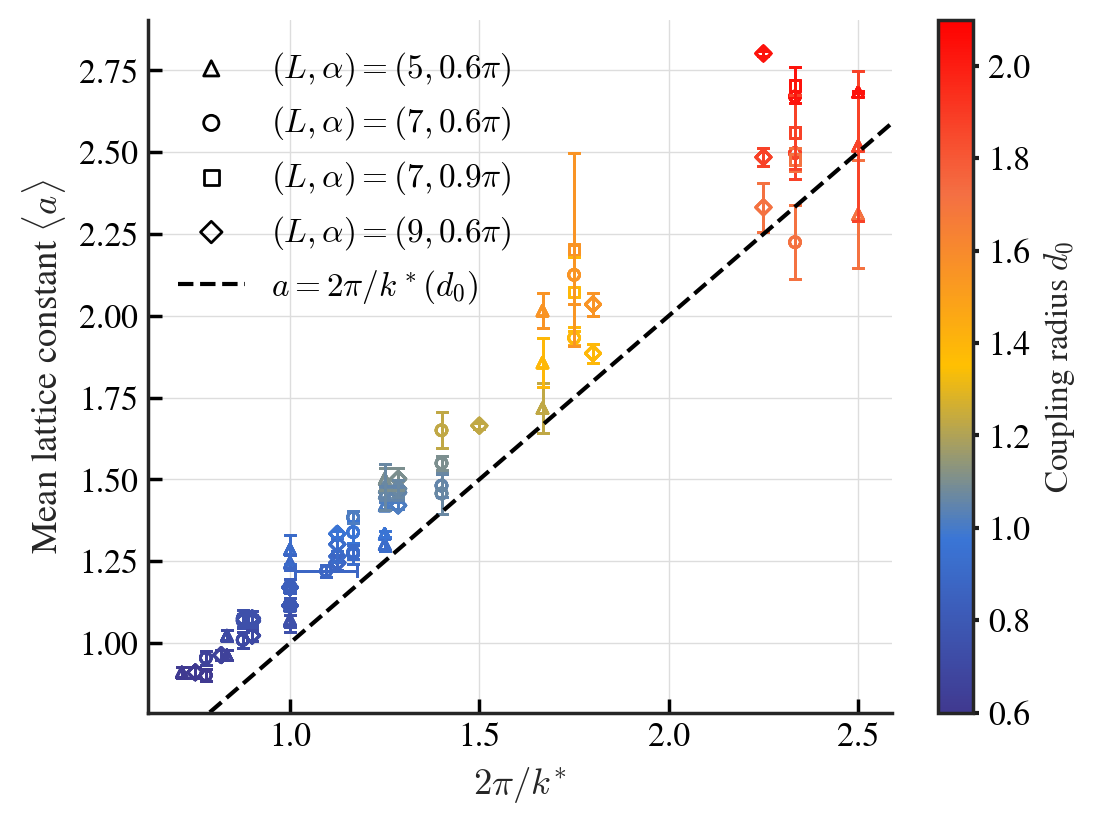

In [150]:
from matplotlib.cm import ScalarMappable

minD0, maxD0 = 0.6, 2.1
speedV = 3

markers = ['^', 'o', 's', 'D']

fig, ax = plt.subplots(figsize=(6, 4.5))
for gIdx, (firstBreakKs, edgeDistances, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params

    KsAndD0s = np.array(list(firstBreakKs.keys()))
    selectKs, selectD0s = KsAndD0s[:, 0], KsAndD0s[:, 1]
    selectKs = selectKs[14 < selectKs]
    selectD0s = selectD0s[(minD0 < selectD0s) & (selectD0s < maxD0)]  # & 

    totalKStars = list()
    totalMeanEdgeDistances = list()

    for i, d0 in enumerate(selectD0s):
        kStars = list()
        meanEdgeDistances = list()

        for K in KsAndD0s[KsAndD0s[:, 1] == d0, 0]:
            firstPosK = firstBreakKs[(K, d0)]
            edgeDistance = edgeDistances[(K, d0)][0]
            meanEdgeDistance = np.mean(edgeDistance) # - speedV / np.abs(K * np.sin(phaseLagA0))
            kStars.append(2 * np.pi / firstPosK)
            meanEdgeDistances.append(meanEdgeDistance)

        meanEdgeDistances, stdEdgeDistance = np.mean(meanEdgeDistances), np.std(meanEdgeDistances)
        meanKstars, stdKstars = np.mean(kStars), np.std(kStars)

        color = cmap((d0 - minD0) / (maxD0 - minD0))
        plt.scatter(
            meanKstars, meanEdgeDistances,
            s=15, alpha=1, marker=markers[gIdx],
            facecolors="none", edgecolors=color
        )
        plt.errorbar(meanKstars, meanEdgeDistances, 
                     xerr=stdKstars, yerr=stdEdgeDistance,
                     color="none", ecolor=color, capsize=2, alpha=1, lw=1)
        totalKStars += kStars
        totalMeanEdgeDistances += meanEdgeDistances

plt.tick_params(length=5, direction="in")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.xlabel(r"$2\pi / k^{*}$")
plt.ylabel(r"Mean lattice constant $\langle a\rangle$")

norm = plt.Normalize(minD0, maxD0)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Coupling radius $d_0$', fontsize=12)
cbar.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.xlim(plt.xlim()[0], plt.xlim()[1])
plt.ylim(plt.ylim()[0], plt.ylim()[1])

for gIdx, (_, _, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params
    plt.scatter([], [], s=30, alpha=1, marker=markers[gIdx],
                facecolors="none", edgecolors="black",
                label=rf"$(L, \alpha)=({boundaryLength}, {phaseLagA0/np.pi:.1f}\pi)$")

slope, intercept = 1, 0
xs = np.array([0.7, 3.5])
plt.plot(xs, 
         slope * xs + intercept,
         color="black", linestyle="--", linewidth=1.5, label=rf"$a=2\pi/k^*(d_0)$")
    
plt.legend(frameon=False, fontsize=12, ncol=1, loc="upper left")  # bbox_to_anchor=(0.48, 0.95), 
plt.savefig("figs/lattice_constant_vs_kstar_discrete.pdf", bbox_inches="tight")

d:\Programs\anaconda3\envs\p312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Programs\anaconda3\envs\p312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


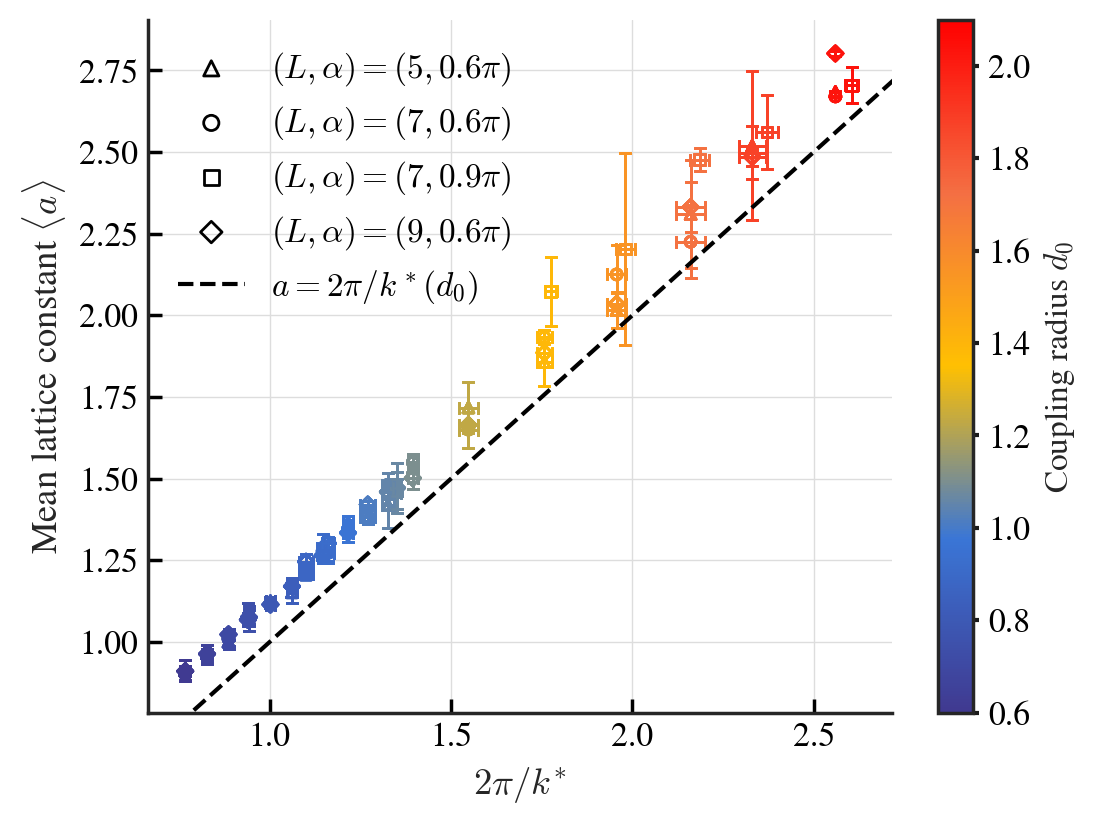

In [148]:
from matplotlib.cm import ScalarMappable

minD0, maxD0 = 0.6, 2.1
speedV = 3

markers = ['^', 'o', 's', 'D']

fig, ax = plt.subplots(figsize=(6, 4.5))
for gIdx, (firstBreakKs, edgeDistances, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params

    KsAndD0s = np.array(list(firstBreakKs.keys()))
    selectKs, selectD0s = KsAndD0s[:, 0], KsAndD0s[:, 1]
    selectKs = selectKs[14 < selectKs]
    selectD0s = selectD0s[(minD0 < selectD0s) & (selectD0s < maxD0)]  # & 

    totalKStars = list()
    totalMeanEdgeDistances = list()

    for i, d0 in enumerate(selectD0s):
        kStars = list()
        meanEdgeDistances = list()

        for K in KsAndD0s[KsAndD0s[:, 1] == d0, 0]:
            firstPosK = firstBreakKs[(K, d0)]
            edgeDistance = edgeDistances[(K, d0)][0]
            meanEdgeDistance = np.mean(edgeDistance) # - speedV / np.abs(K * np.sin(phaseLagA0))
            kStars.append(2 * np.pi / firstPosK)
            meanEdgeDistances.append(meanEdgeDistance)

        meanEdgeDistances, stdEdgeDistance = np.mean(meanEdgeDistances), np.std(meanEdgeDistances)
        meanKstars, stdKstars = np.mean(kStars), np.std(kStars)

        color = cmap((d0 - minD0) / (maxD0 - minD0))
        plt.scatter(
            meanKstars, meanEdgeDistances,
            s=15, alpha=1, marker=markers[gIdx],
            facecolors="none", edgecolors=color
        )
        plt.errorbar(meanKstars, meanEdgeDistances, 
                     xerr=stdKstars, yerr=stdEdgeDistance,
                     color="none", ecolor=color, capsize=2, alpha=1, lw=1)
        totalKStars += kStars
        totalMeanEdgeDistances += meanEdgeDistances

plt.tick_params(length=5, direction="in")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.xlabel(r"$2\pi / k^{*}$")
plt.ylabel(r"Mean lattice constant $\langle a\rangle$")

norm = plt.Normalize(minD0, maxD0)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Coupling radius $d_0$', fontsize=12)
cbar.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.xlim(plt.xlim()[0], plt.xlim()[1])
plt.ylim(plt.ylim()[0], plt.ylim()[1])

for gIdx, (_, _, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params
    plt.scatter([], [], s=30, alpha=1, marker=markers[gIdx],
                facecolors="none", edgecolors="black",
                label=rf"$(L, \alpha)=({boundaryLength}, {phaseLagA0/np.pi:.1f}\pi)$")

slope, intercept = 1, 0
xs = np.array([0.7, 3.5])
plt.plot(xs, 
         slope * xs + intercept,
         color="black", linestyle="--", linewidth=1.5, label=rf"$a=2\pi/k^*(d_0)$")
    
plt.legend(frameon=False, fontsize=12, ncol=1, loc="upper left")  # bbox_to_anchor=(0.48, 0.95), 
plt.savefig("figs/lattice_constant_vs_kstar_continuous.pdf", bbox_inches="tight")

In [ ]:
from matplotlib.cm import ScalarMappable

minD0, maxD0 = 0.6, 2.1
speedV = 3

markers = ['^', 'o', 's', 'D']

fig, ax = plt.subplots(figsize=(6, 4.5))
for gIdx, (firstBreakKs, edgeDistances, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params

    KsAndD0s = np.array(list(firstBreakKs.keys()))
    selectKs, selectD0s = KsAndD0s[:, 0], KsAndD0s[:, 1]
    selectKs = selectKs[14 < selectKs]
    selectD0s = selectD0s[(minD0 < selectD0s) & (selectD0s < maxD0)]  # & 

    totalKStars = list()
    totalMeanEdgeDistances = list()

    for i, d0 in enumerate(selectD0s):
        kStars = list()

        for K in KsAndD0s[KsAndD0s[:, 1] == d0, 0]:
            firstPosK = firstBreakKs[(K, d0)]
            edgeDistance = edgeDistances[(K, d0)][0]
            if len(edgeDistance) < 20:
                continue
            edgeDistance = edgeDistance - speedV / np.abs(K * np.sin(phaseLagA0))
            kStars.append(2 * np.pi / firstPosK)

            meanEdgeDistances, stdEdgeDistance = np.mean(edgeDistance), np.std(edgeDistance)

            color = cmap((d0 - minD0) / (maxD0 - minD0))
            plt.scatter(
                kStars[0], meanEdgeDistances,
                s=15, alpha=1, marker=markers[gIdx],
                facecolors="none", edgecolors=color
            )
            plt.errorbar(kStars[0], meanEdgeDistances, yerr=stdEdgeDistance,
                        color="none", ecolor=color, capsize=2, alpha=1, lw=1)
            totalKStars += kStars
            totalMeanEdgeDistances += meanEdgeDistances

plt.tick_params(length=5, direction="in")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.xlabel(r"$2\pi / k^{*}$")
plt.ylabel(r"Mean lattice constant $\langle a\rangle$")

norm = plt.Normalize(minD0, maxD0)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Coupling radius $d_0$', fontsize=12)
cbar.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.xlim(plt.xlim()[0], plt.xlim()[1])
plt.ylim(plt.ylim()[0], plt.ylim()[1])

for gIdx, (_, _, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params
    plt.scatter([], [], s=30, alpha=1, marker=markers[gIdx],
                facecolors="none", edgecolors="black",
                label=rf"$(L, \alpha)=({boundaryLength}, {phaseLagA0/np.pi:.1f}\pi)$")

slope, intercept = 1, 0
xs = np.array([0.7, 3.5])
plt.plot(xs, 
         slope * xs + intercept,
         color="black", linestyle="--", linewidth=1.5, label=rf"$a=2\pi/k^*(d_0)$")
    
# plt.text(x=0.97, y=2.65, s=r"$L\ \ \ \alpha$", fontsize=12)
plt.legend(frameon=False, fontsize=12, ncol=1, loc="upper left")  # bbox_to_anchor=(0.48, 0.95), 
# plt.savefig("figs/lattice_constant_vs_kstar.pdf", bbox_inches="tight")

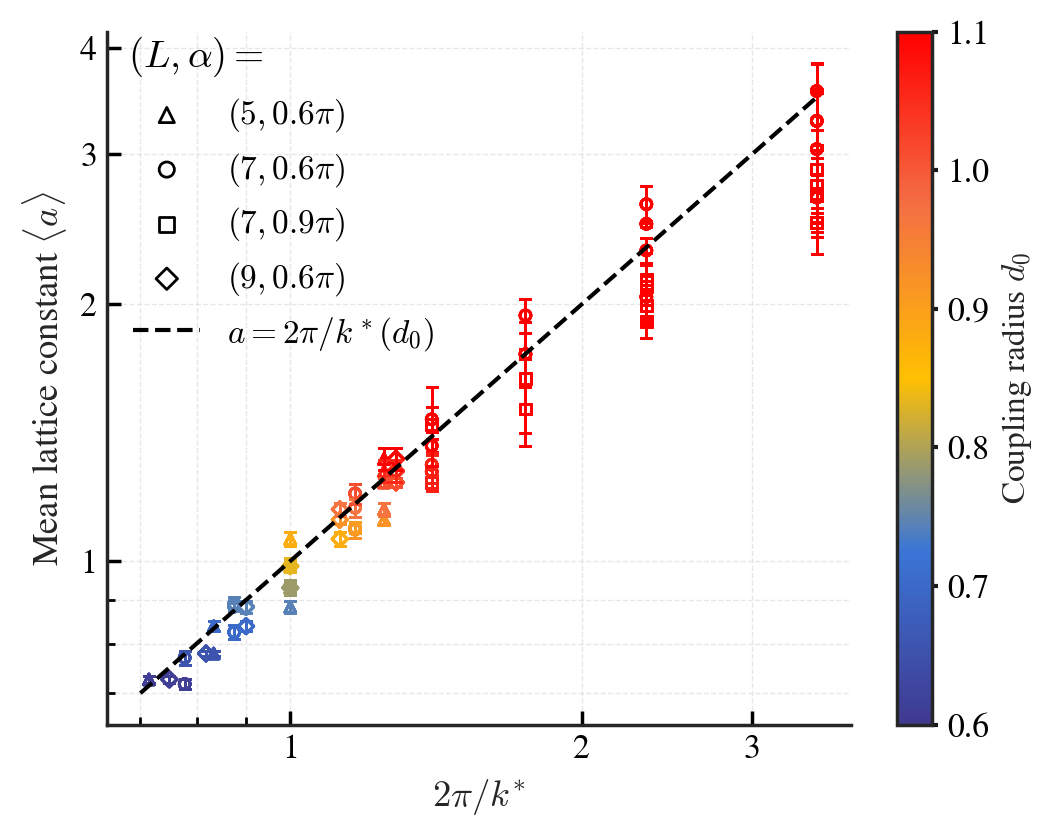

In [38]:
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker

minD0, maxD0 = 0.6, 1.1
speedV = 3

markers = ['^', 'o', 's', 'D']

fig, ax = plt.subplots(figsize=(6, 4.5))
for gIdx, (firstBreakKs, edgeDistances, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params

    KsAndD0s = np.array(list(firstBreakKs.keys()))
    selectKs, selectD0s = KsAndD0s[:, 0], KsAndD0s[:, 1]
    selectKs = selectKs[14 < selectKs]
    selectD0s = selectD0s[0.6 < selectD0s]

    totalKStars = list()
    totalMeanEdgeDistances = list()

    for i, d0 in enumerate(selectD0s):
        kStars = list()
        meanEdgeDistances = list()

        for K in KsAndD0s[KsAndD0s[:, 1] == d0, 0]:
            firstPosK = firstBreakKs[(K, d0)]
            edgeDistance = edgeDistances[(K, d0)][0]
            if len(edgeDistance) < 20:
                continue
            meanEdgeDistance = np.mean(edgeDistance) - speedV / np.abs(K * np.sin(phaseLagA0))
            kStars.append(2 * np.pi / firstPosK)
            meanEdgeDistances.append(meanEdgeDistance)

        if len(np.unique(kStars)) > 1 or len(kStars) == 0:
            continue

        meanEdgeDistances, stdEdgeDistance = np.mean(meanEdgeDistances), np.std(meanEdgeDistances)

        color = cmap((d0 - minD0) / (maxD0 - minD0))
        plt.scatter(
            kStars[0], meanEdgeDistances,
            s=15, alpha=1, marker=markers[gIdx],
            facecolors="none", edgecolors=color
        )
        plt.errorbar(kStars[0], meanEdgeDistances, yerr=stdEdgeDistance,
                    color="none", ecolor=color, capsize=2, alpha=1, lw=1)
        totalKStars += kStars
        totalMeanEdgeDistances += meanEdgeDistances

plt.semilogx()
plt.semilogy() 

ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

# nbins = 4
# ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins))
# ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins))
plt.xticks([1, 2, 3, 4])
plt.yticks([1, 2, 3, 4])

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel(r"$2\pi / k^{*}$")
plt.ylabel(r"Mean lattice constant $\langle a\rangle$")

norm = plt.Normalize(minD0, maxD0)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Coupling radius $d_0$', fontsize=12)
cbar.ax.tick_params(length=2, direction="out", color="k", width=1.5)

for gIdx, (_, _, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params
    plt.scatter([], [], s=30, alpha=1, marker=markers[gIdx],
                facecolors="none", edgecolors="black",
                label=rf"$({boundaryLength}, {phaseLagA0/np.pi:.1f}\pi)$")
    
slope, intercept = 1, 0
xs = np.array([0.7, 3.5])
plt.plot(xs, 
         slope * xs + intercept,
         color="black", linestyle="--", linewidth=1.5, label=rf"$a=2\pi/k^*(d_0)$")
    
plt.text(x=0.68, y=3.8, s=r"$(L,\alpha)=$", fontsize=14)
plt.legend(bbox_to_anchor=(0.48, 0.95), frameon=False, fontsize=12, ncol=1)

plt.tick_params(which='both', length=5, direction="in")
plt.tick_params(which='minor', length=3, direction="in")
# plt.savefig("figs/lattice_constant_vs_kstar.pdf", bbox_inches="tight")

In [ ]:
# selectD0s = distanceD0s[1:]  # 3000 uniform
# selectKsDict = {
#     selectD0s[0]: strengthKs[-2:],
#     selectD0s[1]: strengthKs[2:],
#     selectD0s[2]: strengthKs[2:],
#     selectD0s[3]: strengthKs[1:],
#     selectD0s[4]: strengthKs[1:],
#     selectD0s[5]: strengthKs[1:],
# }
selectD0s = distanceD0s[2:]  # 2000 cauchy
selectKsDict = {
    selectD0s[0]: strengthKs[-3:],
    selectD0s[1]: strengthKs[3:],
    selectD0s[2]: strengthKs[3:],
    selectD0s[3]: strengthKs[3:],
    selectD0s[4]: strengthKs[2:]
}

fig, ax = plt.subplots(figsize=(6, 5))

for i, selectD0 in enumerate(selectD0s):
    meanEdgeDistances = [edgeDistances[(strengthK, selectD0)].mean() for strengthK in selectKsDict[selectD0]]
    stdEdgeDistances = [edgeDistances[(strengthK, selectD0)].std() for strengthK in selectKsDict[selectD0]]
    # analysisDis = [
    #     selectD0 + 2 * model.speedV / np.abs(strengthK * np.sin(model.phaseLagA0))
    #     for strengthK in selectKsDict[selectD0]
    # ]
    linspaceKs = np.linspace(
        selectKsDict[selectD0][0], selectKsDict[selectD0][-1], 100
    )
    analysisDis = selectD0 + 2 * model.speedV / np.abs(linspaceKs * np.sin(model.phaseLagA0))

    plt.plot(linspaceKs, analysisDis, ls="--")
    # ax.errorbar(selectKsDict[selectD0], meanEdgeDistances, yerr=stdEdgeDistances,
    #             color="none", ecolor=f"C{i}", capsize=3, ms=4)
    ax.scatter(selectKsDict[selectD0], meanEdgeDistances, color=f"C{i}", label=f"$d_0={selectD0:.2f}$")

plt.legend(fontsize=8)
# plt.ylim(0, 1.5)

In [ ]:
model.distanceD0 + 2 * model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

In [ ]:
plt.plot([i.mean() for i in edgeDistances.values()])
plt.axhline(y=model.distanceD0 + 2 * model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0)),
            color="black", ls="--", lw=1.5, label="Theoretical distance")

In [ ]:
# model = [model for model in models 
#       if (model.distanceD0 == distanceD0s[2]) and 
#       (model.strengthK == strengthKs[-1])][0]
# sa = StateAnalysis(model)

sa: StateAnalysis = [sa for sa in sas
      if (sa.model.distanceD0 == distanceD0s[2]) and
      (sa.model.strengthK == strengthKs[-1])][0]
model = sa.model

shift = np.array([0., 0.])
analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

classes, centers = sa.calc_classes_and_centers(classDistance=analysisRadius, lookIdx=-1)
if len(classes) > model.agentsNum * 0.2:
    print(f"Too many classes: {len(classes)} > {model.agentsNum * 0.2}, skipping.")
    # return [], [], []
numInClasses = np.array([len(c) for c in classes])
# zScoreNum = stats.zscore(numInClasses)
# classes = [classes[c] for c in range(len(classes)) 
#            if (zScoreNum[c] > -0.4) and (numInClasses[c] > 10)]
numThres = np.median(numInClasses[numInClasses > 10]) * 0.
classes = [classes[c] for c in range(len(classes))
            if (numInClasses[c] > max(numThres, 10))]
centers = np.mod(centers + shift, model.boundaryLength)
if len(classes) <= 1:
    print("Not enough classes, skipping.")
    # return [], [], []

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

len(classes)

In [ ]:
sa.plot_spatial(colorsBy="phase", index=-1, shift=shift)
plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=30, edgecolor="black", lw=1.5
)

In [ ]:
from scipy import stats

shift = np.array([0., 0.])
analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

classes, centers = sa.calc_classes_and_centers(classDistance=analysisRadius, lookIdx=-1)
if len(classes) > model.agentsNum * 0.2:
    print(f"Too many classes: {len(classes)} > {model.agentsNum * 0.2}, skipping.")
    # return [], []
numInClasses = np.array([len(c) for c in classes])
# zScoreNum = stats.zscore(numInClasses)
# classes = [classes[c] for c in range(len(classes)) 
#            if (zScoreNum[c] > -0.4) and (numInClasses[c] > 10)]
numThres = np.median(numInClasses[numInClasses > 10]) * 0.
classes = [classes[c] for c in range(len(classes))
            if (numInClasses[c] > max(numThres, 10))]
centers = np.mod(centers + shift, model.boundaryLength)
if len(classes) <= 1:
    print("Not enough classes, skipping.")
    # return [], [], []

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

edges, ajdClassCenters = sa.calc_nearby_edges(
    classCenters=classCenters, 
    stdMulti=0.3,
    relativeDistance=False
)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=30, edgecolor="black", lw=1.5
)

for edge in edges[:]:
    plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
             color="black", lw=1.2, alpha=0.3, zorder=0
            #  linestyle=(0, (10, 2))
             )
    # edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    # edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    # edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    # edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.5 * model.distanceD0

    # plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
    #          [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
    #          lw=2, alpha=1, color="gray", ls="-")

analRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

for classCenter in classCenters:
    circle = plt.Circle(
        classCenter, analRadius * 1, color="black", fill=False, lw=1, alpha=1, ls="-"
    )
    ax.add_artist(circle)

sa.plot_spatial(ax=ax, colorsBy="phase", index=-1, shift=shift)

# for i, classCenter in enumerate(classCenters):
#     plt.text(
#         classCenter[0] + 0.01, classCenter[1] + 0.1, 
#         f"{i}", ha="left", va="bottom", fontsize=12, color="black"
#     )

plt.tick_params(length=3, direction="in")


In [ ]:
model.distanceD0 + analRadius * 2

In [ ]:
relativeEdges = np.unique(np.mod(edges, len(classes)), axis=0)
np.mean([
    sa.calc_replative_distance(classCenters[edge[0]], classCenters[edge[1]])
    # np.linalg.norm(classCenters[edge[0]] - classCenters[edge[1]])
    for edge in relativeEdges
])

In [ ]:
np.mean([
    np.linalg.norm(ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]])
    for edge in edges
])